### Mars lander code with inclusion of parachute and drag force

#### Changes made:
- parachute added to autopilot
- Drag force included in equations of mass
- height increased to 16km - earlier simulation stage
- N increased so that simulation lasts longer

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interactive  # what is ipywidgets - slider
from matplotlib import rcParams  # what is rcParams
from numpy.linalg import norm
from numpy.random import randint
import json      #ADDED FOR SAVING FILES
from mpl_toolkits import mplot3d #added for 3D plotting
from scipy.optimize import minimize   # for minimising landing speed

rcParams['figure.figsize'] = (10, 8)

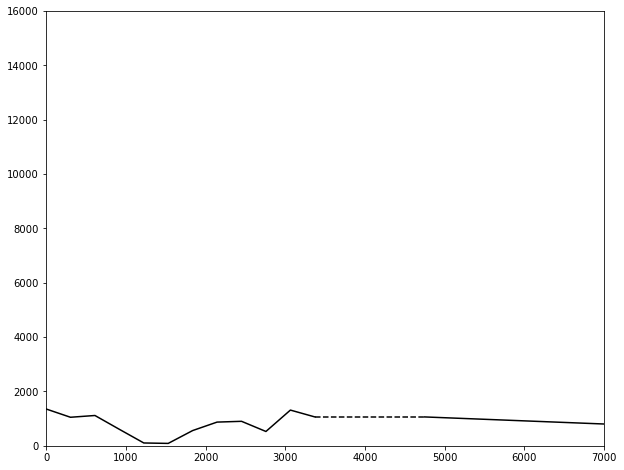

In [4]:

def mars_surface():
    surfaceN = randint(5, 15)
    land = np.zeros((surfaceN, 2), dtype=int)
    
    # first ensure there's a flat landing site at least 1000m long
    landing_site = randint(1, surfaceN-1)
    land[landing_site, 0] = randint(2000, 5000)
    land[landing_site+1, 0] = min(land[landing_site, 0] + randint(1000, 2000), 6999)
    land[landing_site+1, 1] = land[landing_site, 1] = randint(1, 1500)
    
    # fill in the rest of the terrain
    for i in range(landing_site):
        land[i, 0] = (land[landing_site, 0] / landing_site) * i
        land[i, 1] = randint(0, 1500)
    
    for i in range(landing_site + 2, surfaceN):
        land[i, 0] = (land[landing_site + 1, 0] + 
                      (7000 - land[landing_site + 1, 0]) / len(land[landing_site + 2:]) * 
                      (i - (landing_site + 1)))
        land[i, 1] = randint(0, 1500)
    
    # impose boundary conditions
    land[0, 0] = 0
    land[-1, 0] = 6999

    return land, landing_site

def plot_surface(land, landing_site):
    fig, ax = plt.subplots()
    ax.plot(land[:landing_site+1, 0], land[:landing_site+1, 1], 'k-')
    ax.plot(land[landing_site+1:, 0], land[landing_site+1:, 1], 'k-')
    ax.plot([land[landing_site, 0], land[landing_site+1, 0]], 
             [land[landing_site, 1], land[landing_site+1, 1]], 'k--')
    ax.set_xlim(0, 7000)
    ax.set_ylim(0, 16000) # HERE was 13000
    return ax

def plot_lander(land, landing_site, X, thrust=None, animate=False, step=10):
    if animate:
        def plot_frame(n=len(X)-1):
            ax = plot_surface(land, landing_site)
            ax.plot(X[:n, 0], X[:n, 1], 'b--')
            ax.plot(X[n, 0], X[n, 1], 'b^', ms=20)
            if thrust is not None:
                ax.plot([X[n, 0], X[n, 0] - 100*thrust[n, 0]],
                        [X[n, 1] - 100., X[n, 1] - 100. - 100*thrust[n, 1]], 
                       'r-', lw=10)
        return interactive(plot_frame, n=(0, len(X), step)) #slider
    else:
        ax = plot_surface(land, landing_site) 
        ax.plot(X[:, 0], X[:, 1], 'b--')
        ax.plot(X[-1, 0], X[-1, 1], 'b^')
        return ax

def interpolate_surface(land, x):
    i,  = np.argwhere(land[:, 0] < x)[-1] # segment containing x is [i, i+1]
    m = (land[i+1, 1] - land[i, 1])/(land[i+1, 0] - land[i, 0]) # gradient
    x1, y1 = land[i, :] # point on line with eqn. y - y1 = m(x - x1) 
    return m*(x - x1) + y1

#np.random.seed(20) # seed random number generator for reproducible results
land, landing_site = mars_surface()
#plot_surface(land, landing_site);


def height(land, X):
    return X[1] - interpolate_surface(land, X[0]) #1 in X[1] points to the vertical position y of the lander

assert abs(height(land, [1, land[0, 1]])) < 100.0 # height when on surface left edge should be close to zero
assert abs(height(land, [6999, land[-1, 1]])) < 100.0 # height when on surface at right edge should be close to zero

_land, _landing_site = mars_surface()

## ELIMINATE either above or below

def _height(_land, X):
    return X[1] - interpolate_surface(_land, X[0])

points = np.zeros((10, 2))
points[:, 0] = randint(0, 7000, size=10)
points[:, 1] = randint(0, 16000, size=10) # HERE was 13000
for i in range(10):
    assert abs(height(_land, points[i, :]) - _height(_land, points[i, :])) < 1e-6



In [5]:
g = 3.711 # m/s^2 , gravity on Mars
TSFC = 0.0003 # kg/(N*s)
# fuel in kg
Dc = 6.3525 # drag force as a function of velocity

def simulate(X0, V0, land, landing_site, 
             fuel=400, dt=0.1, Nstep=1000, 
             autopilot=None, print_interval=100, parameters=None, parachute=None):
    
    n = len(X0)       # number of degrees of freedom (2 here)
    X = X0.copy()     # current position
    V = V0.copy()     # current velocity
    Xs = np.zeros((Nstep, n)) # position history (trajectory) 
    Vs = np.zeros((Nstep, n)) # velocity history
    thrust = np.zeros((Nstep, n)) # thrust history
    success = False
    fuel_warning_printed = False
    rotate = 0           # degrees,
    power = 0            # m/s^2, initial thrust power    

    for i in range(Nstep):
        Xs[i, :] = X     # Store positions
        Vs[i, :] = V     # Store velocities
        
        if autopilot is not None:
            
            rotate, power, parachute = autopilot(i, X, V, fuel, rotate, power, parameters, parachute)    #HERE 
            assert abs(rotate) <= 90
            assert 0 <= power <= 20000 #changed from 4000, then 12 000
        
            rotate_rad = rotate * np.pi / 180.0 # degrees to radians
            thrust[i, :] = power * np.array([np.sin(rotate_rad), 
                                             np.cos(rotate_rad)])
            if fuel <= 0: 
                if not fuel_warning_printed:
                    print("Fuel empty! Setting thrust to zero")
                    fuel_warning_printed = True
                thrust[i, :] = 0
            else:
                fuel -= TSFC * power * dt
                
        m = 2600 + fuel  #kg , Mass of Lander + Rover + fuel  # fuel Mass loss
        
        if parachute == 0:
            # no Drag
            drag = 0
        else: # parachute == 1
            # Drag - Parachute deployed
            drag = Dc*(V[1]**2)            
        
        A = np.array([0, -g+(drag/m)]) + thrust[i, :]/m 
                                   
        V += A * dt                          
        X += V * dt
        
        if i % print_interval == 0: 
            print(f"i={i:03d} X=[{X[0]:8.3f} {X[1]:8.3f}] V=[{V[0]:8.3f} {V[1]:8.3f}]"
                  f" thrust=[{thrust[i, 0]:8.3f} {thrust[i, 1]:8.3f}] fuel={fuel:8.3f} parachute={parachute:8.3f}") 
        
        # check for safe or crash landing
        if X[1] < interpolate_surface(land, X[0]):
            if not (land[landing_site, 0] <= X[0] and X[0] <= land[landing_site + 1, 0]):
                print("crash! did jot land on flat ground!")
            elif rotate != 0:
                print("crash! did not land in a vertical position (tilt angle = 0 degrees)")
            elif abs(V[1]) >= 40:
                print("crash! vertical speed must be limited (<40m/s in absolute value), got ", abs(V[1]))
            elif abs(V[0]) >= 20:
                print("crash! horizontal speed must be limited (<20m/s in absolute value), got ", abs(V[0]))
            else:
                print("safe landing - well done!")
                success = True
            Nstep = i
            break
    
    return Xs[:Nstep,:], Vs[:Nstep,:], thrust[:Nstep,:], success, fuel, parachute 

## AUTOPILOT TO CONTROL THE LANDER

def proportional_autopilot(i, X, V, fuel, rotate, power,parameters, parachute):
        
    K_h,K_p = parameters
    c = 10.0 # target landing speed, m/s                            
    h = height(land, X)
    e = - (c + K_h*h + V[1])          
    Pout = K_p*e                     
    power = min(max(Pout, 0.0), 20000)  # by 1000 HERE
    
    if h>10000:
        parachute = 0 
    else:
        parachute = 1 #open parachute
        
    if i % 100 == 0:
        print(f'e={e:8.3f} Pout={Pout:8.3f} power={power:8.3f}')     
    return (rotate, power,parachute)


In [11]:
#Test: different K values:

#np.random.seed(123) # seed random number generator for reproducible results
land, landing_site = mars_surface()

K_h_list = [0.01] 
K_p_list = [500] 

count = 0
land_speed_results = np.zeros((len(K_h_list),len(K_p_list)))
fuel_results = np.zeros((len(K_h_list),len(K_p_list)))

for i, K_h in enumerate(K_h_list):
    for j, K_p in enumerate(K_p_list):
        X0 = [randint(1000, 5000), randint(14000, 16000)] # HERE was 13000
        V0 = [0, randint(-50,-10)] #intial velocity  (randint(-50,50) for horizontal when angle implemented)
        #print(f'X0={X0} V0={V0}')
        Xs, Vs, thrust, success, fuel,parachute = simulate(X0, V0, land, landing_site, dt=0.1, Nstep=3000, 
                                        autopilot=proportional_autopilot, fuel=400,parameters=[K_h,K_p],parachute=None) # HERE
        land_speed_results[i, j] = Vs[-1,1]
        fuel_results[i, j] = fuel
        count += success

plot_lander(land, landing_site, Xs, thrust, animate=True, step=10)

e= -99.050 Pout=-49525.000 power=   0.000
i=000 X=[3686.000 14042.863] V=[   0.000  -41.371] thrust=[   0.000    0.000] fuel= 400.000 parachute=   0.000
e= -55.966 Pout=-27982.973 power=   0.000
i=100 X=[3686.000 13441.746] V=[   0.000  -78.481] thrust=[   0.000    0.000] fuel= 400.000 parachute=   0.000
e=  -9.171 Pout=-4585.445 power=   0.000
i=200 X=[3686.000 12469.530] V=[   0.000 -115.591] thrust=[   0.000    0.000] fuel= 400.000 parachute=   0.000
e=  22.437 Pout=11218.592 power=11218.592
i=300 X=[3686.000 11183.261] V=[   0.000 -133.979] thrust=[   0.000 11218.592] fuel= 383.198 parachute=   0.000
e= -51.883 Pout=-25941.407 power=   0.000
i=400 X=[3686.000 10382.038] V=[   0.000  -51.373] thrust=[   0.000    0.000] fuel= 377.859 parachute=   1.000
e= -55.652 Pout=-27826.184 power=   0.000
i=500 X=[3686.000 9922.550] V=[   0.000  -43.169] thrust=[   0.000    0.000] fuel= 377.859 parachute=   1.000
e= -52.658 Pout=-26328.974 power=   0.000
i=600 X=[3686.000 9498.791] V=[   0.000  

interactive(children=(IntSlider(value=2826, description='n', max=2827, step=10), Output()), _dom_classes=('wid…

### PID CONTROLLER

In [ ]:
Pout = K_p*(e + K_i* integral(e) + K_d*derivative(e)
            
In simulate:
            
              for i in range(Nstep):
        Xs[i, :] = X     # Store positions
        Vs[i, :] = V     # Store velocities
            ADD
        t[i, :] = i ??